<a href="https://colab.research.google.com/github/loosiu/pdm14/blob/main/py-tensorflow/pdm14_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### trainsfer learning(TL)이란
- 이미 훈련된 모델의 일부를 가져와 새 모델에서 재사용함으로써 손쉽게 데이터를 구축하는 기술


### cifar10에 대한 TL 결과 요약
1. cifar10의 10% 데이터에서 MobileNetV2 모델을 이용해서 학습하였습니다
2. 10%의 데이터이기 때문에 데이터가 적어서 Data augmentation으로 데이터를 증식시켜서 학습하였습니다
3. Data augmentation을 시킨 모델을 활용해서 fine tuning으로 재학습하였습니다 

* trial and error: Data augmentation으로 학습시킬 때 datagen.flow 함수를 활용해서 학습시켰었는데 정확도가 약 0.09로 나와서 시행착오를 겪었습니다.
그래서 구글링을 해보니 tf.reshape(y_train, (-1))를 써서 차원을 바꿔주면 정확도가 올라간다고 하여서 해보니 정상적으로 작동되었습니다

In [ ]:
from tensorflow.keras.applications.mobilenet_v2 import  MobileNetV2, preprocess_input
import tensorflow.keras as keras
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
import tensorflow as tf
from keras.utils import np_utils
from keras.models import load_model
from keras.datasets import cifar10
from keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
# import cv2
print(tf.__version__)

2.7.0


In [ ]:
tf.keras.backend.clear_session()  

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print("#### ", len(gpus), "Physical GPUs,",
                 len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)
else:
    print('#### No CUDA supported GPU in this computer.')

####  1 Physical GPUs, 1 Logical GPUs


In [ ]:
TL_base = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

9420800/9406464 [==============================] - 0s 0us/step


In [ ]:
(x_train0, y_train), (x_test0, y_test) = cifar10.load_data()

x_train = x_train0.astype('float32')
x_test = x_test0.astype('float32')

x_train = preprocess_input(x_train)
x_test = preprocess_input(x_test)

x_train=x_train
x_test=x_test
print(x_train0.shape)
print(x_train.shape)
print(x_test.shape)

170508288/170498071 [==============================] - 2s 0us/step
(50000, 32, 32, 3)
(50000, 32, 32, 3)
(10000, 32, 32, 3)


In [ ]:
x_train = x_train[0:5000]
y_train = y_train[0:5000]
print(x_train.shape)
print(y_test.shape)

(5000, 32, 32, 3)
(10000, 1)


In [ ]:
TL_base.trainable = False  

In [ ]:
tf.random.set_seed(1234)
model = models.Sequential()
model.add(keras.Input(shape=(32,32,3)))
model.add(layers.UpSampling2D((7,7)))  # 32*7 = 224
model.add(TL_base)
model.add(layers.GlobalAveragePooling2D()) # (7,7,2048) => (2048,)
model.add(layers.Flatten())
model.add(layers.BatchNormalization())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.BatchNormalization())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.BatchNormalization())
model.add(layers.Dense(10, activation='softmax'))

# model.compile(optimizer=optimizers.RMSprop(lr=2e-5), loss='binary_crossentropy', metrics=['acc'])
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) 
model.compile(optimizer='SGD', 
                loss='sparse_categorical_crossentropy',  # sparse_categorical_crossentropy
                metrics = ['accuracy'])

In [ ]:
from tensorflow.keras import layers, models, callbacks

In [ ]:
mc_callback = callbacks.ModelCheckpoint(filepath="./model/cifar10_mobileNetV2S_SGD_best_weights.{epoch:03d}-{val_accuracy:.4f}.hdf5", 
                              monitor='val_accuracy', verbose=0, save_best_only=True)
es_callback = callbacks.EarlyStopping(monitor='val_accuracy', 
                            mode='max', verbose=1, patience=5)

In [ ]:
history = model.fit(x_train, y_train, 
                    epochs=100, batch_size=32, 
                    validation_data=(x_test, y_test),
                    callbacks=[mc_callback,es_callback])

Epoch 1/100
157/157 [==============================] - ETA: 0s - loss: 2.2023 - accuracy: 0.2864

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


157/157 [==============================] - 51s 244ms/step - loss: 2.2023 - accuracy: 0.2864 - val_loss: 1.4415 - val_accuracy: 0.5207
Epoch 2/100
157/157 [==============================] - 36s 232ms/step - loss: 1.6163 - accuracy: 0.4488 - val_loss: 1.2052 - val_accuracy: 0.5800
Epoch 3/100
157/157 [==============================] - 36s 232ms/step - loss: 1.4300 - accuracy: 0.5124 - val_loss: 1.1136 - val_accuracy: 0.6119
Epoch 4/100
157/157 [==============================] - 36s 231ms/step - loss: 1.3216 - accuracy: 0.5462 - val_loss: 1.0651 - val_accuracy: 0.6270
Epoch 5/100
157/157 [==============================] - 36s 231ms/step - loss: 1.2114 - accuracy: 0.5736 - val_loss: 1.0390 - val_accuracy: 0.6364
Epoch 6/100
157/157 [==============================] - 36s 232ms/step - loss: 1.1497 - accuracy: 0.6034 - val_loss: 1.0067 - val_accuracy: 0.6490
Epoch 7/100
157/157 [==============================] - 36s 232ms/step - loss: 1.0957 - accuracy: 0.6090 - val_loss: 0.9929 - val_accurac

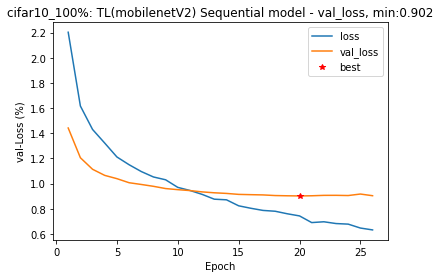

In [ ]:

epochs = range(1, len(history.history['loss']) + 1)

loss_list = history.history['loss'] 
vloss_list = history.history['val_loss']

plt.plot(epochs,loss_list)  
plt.plot(epochs,vloss_list)

plt.plot(np.argmin(np.array(vloss_list))+1,vloss_list[np.argmin(np.array(vloss_list))], 'r*')
plt.title('cifar10_100%: TL(mobilenetV2) Sequential model - val_loss, min:' + str(np.round(vloss_list[np.argmin(np.array(vloss_list))],3)))
plt.ylabel('val-Loss (%)')
plt.xlabel('Epoch')
plt.legend(['loss','val_loss','best'], loc='best')
plt.show()

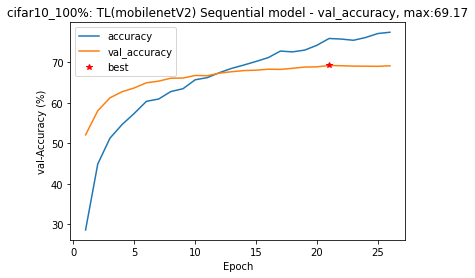

In [ ]:
epochs = range(1, len(history.history['accuracy']) + 1)

acc_list = [100 * i for i in history.history['accuracy']]
vacc_list = [100 * i for i in history.history['val_accuracy']]

plt.plot(epochs,acc_list)  
plt.plot(epochs,vacc_list)

plt.plot(np.argmax(np.array(vacc_list))+1,vacc_list[np.argmax(np.array(vacc_list))], 'r*')
plt.title('cifar10_100%: TL(mobilenetV2) Sequential model - val_accuracy, max:' + str(np.round(vacc_list[np.argmax(np.array(vacc_list))],3)))
plt.ylabel('val-Accuracy (%)')
plt.xlabel('Epoch')
plt.legend(['accuracy','val_accuracy','best'], loc='best')
plt.show()

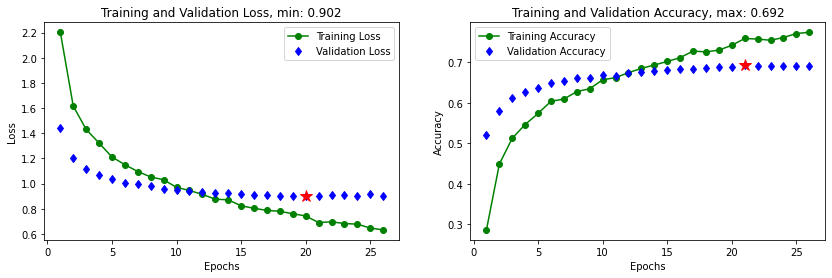

In [ ]:
history_dict = history.history
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure(figsize=(14, 4))

plt.subplot(1,2,1)
plt.plot(epochs, loss, 'go-', label='Training Loss')
plt.plot(epochs, val_loss, 'bd', label='Validation Loss')
plt.plot(np.argmin(np.array(val_loss))+1,val_loss[np.argmin(np.array(val_loss))], 'r*', ms=12)
plt.title('Training and Validation Loss, min: ' + str(np.round(val_loss[np.argmin(np.array(val_loss))],3)))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

epochs = range(1, len(loss) + 1)

plt.subplot(1,2,2)
plt.plot(epochs, acc, 'go-', label='Training Accuracy') #, c='blue')
plt.plot(epochs, val_acc, 'bd', label='Validation Accuracy') #, c='red')
plt.plot(np.argmax(np.array(val_acc))+1,val_acc[np.argmax(np.array(val_acc))], 'r*', ms=12)
plt.title('Training and Validation Accuracy, max: ' + str(np.round(val_acc[np.argmax(np.array(val_acc))],3)))
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


916


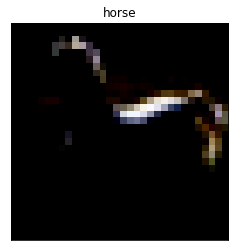

In [ ]:
class_names =  ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

idx = np.random.randint(0, x_train.shape[0])
print(idx)
image = x_train[idx]
plt.imshow(image) #, cmap=plt.get_cmap('gray'))
plt.title(class_names[y_train[idx][0]])
plt.xticks([])
plt.yticks([])
plt.show()

In [ ]:
datagen = ImageDataGenerator(
    rotation_range=10,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
    )
datagen.fit(x_train)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(32, 32, 32, 3) (32, 1)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

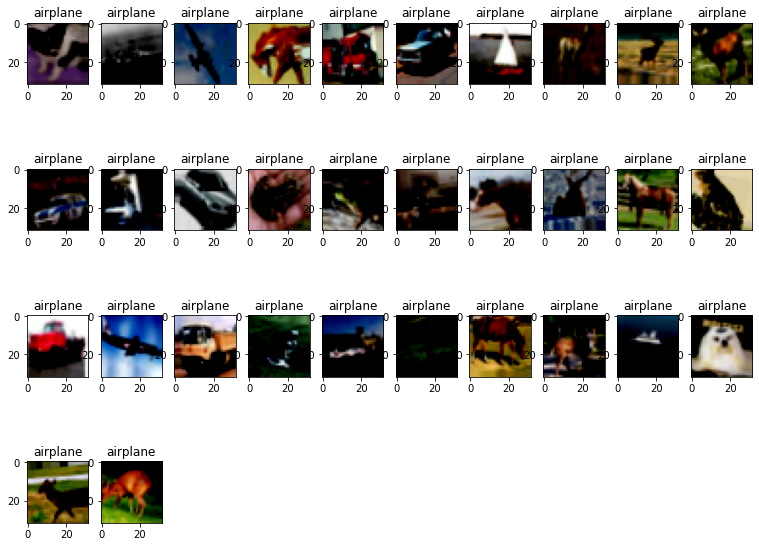

In [ ]:
BATCH_SIZE = 32
for X_batch, y_batch in datagen.flow(x_train, y_train, batch_size=BATCH_SIZE):
    print(X_batch.shape, y_batch.shape)

    plt.figure(figsize=(13,13))
    for i in range(BATCH_SIZE):
        plt.subplot(5,10,i+1)
        plt.imshow(X_batch[i]) 
        plt.title(class_names[np.argmax(y_batch[i])])
    plt.show()
    break

In [ ]:
tf.random.set_seed(1234)
model = models.Sequential()
model.add(keras.Input(shape=(32,32,3)))
model.add(layers.UpSampling2D((7,7)))  # 32*7 = 224
model.add(TL_base)
model.add(layers.GlobalAveragePooling2D()) # (7,7,2048) => (2048,)
model.add(layers.Flatten())
model.add(layers.BatchNormalization())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.BatchNormalization())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.BatchNormalization())
model.add(layers.Dense(10, activation='softmax'))

# model.compile(optimizer=optimizers.RMSprop(lr=2e-5), loss='binary_crossentropy', metrics=['acc'])
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) 
model.compile(optimizer='SGD', 
                loss='sparse_categorical_crossentropy',  # sparse_categorical_crossentropy
                metrics = ['accuracy'])

In [ ]:
mc_callback = callbacks.ModelCheckpoint(filepath="./model/cifar10_mobileNetV2S_SGD_best_weights.{epoch:03d}-{val_accuracy:.4f}.hdf5", 
                              monitor='val_accuracy', verbose=0, save_best_only=True)
es_callback = callbacks.EarlyStopping(monitor='val_accuracy', 
                            mode='max', verbose=1, patience=5)

In [ ]:
epochs = 100
BATCH_SIZE = 32
hist = model.fit(datagen.flow(x_train, tf.reshape(y_train, (-1)), batch_size=BATCH_SIZE),
                 steps_per_epoch=x_train.shape[0]//BATCH_SIZE, 
                 epochs=epochs, verbose=1, 
                 callbacks=[mc_callback, es_callback], 
                 validation_data=(x_test,y_test))

Epoch 1/100
156/156 [==============================] - 38s 231ms/step - loss: 1.3899 - accuracy: 0.5203 - val_loss: 1.1960 - val_accuracy: 0.5998
Epoch 2/100
156/156 [==============================] - 36s 231ms/step - loss: 1.3143 - accuracy: 0.5457 - val_loss: 1.2053 - val_accuracy: 0.6006
Epoch 3/100
156/156 [==============================] - 36s 231ms/step - loss: 1.2466 - accuracy: 0.5713 - val_loss: 1.1941 - val_accuracy: 0.6029
Epoch 4/100
156/156 [==============================] - 36s 232ms/step - loss: 1.2700 - accuracy: 0.5604 - val_loss: 1.1719 - val_accuracy: 0.6043
Epoch 5/100
156/156 [==============================] - 36s 234ms/step - loss: 1.2248 - accuracy: 0.5723 - val_loss: 1.1711 - val_accuracy: 0.6014
Epoch 6/100
156/156 [==============================] - 36s 235ms/step - loss: 1.1818 - accuracy: 0.5837 - val_loss: 1.1440 - val_accuracy: 0.6093
Epoch 7/100
156/156 [==============================] - 36s 235ms/step - loss: 1.1553 - accuracy: 0.5892 - val_loss: 1.1391 -

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


156/156 [==============================] - 37s 237ms/step - loss: 1.0233 - accuracy: 0.6351 - val_loss: 1.0869 - val_accuracy: 0.6286
Epoch 15/100
156/156 [==============================] - 37s 236ms/step - loss: 1.0258 - accuracy: 0.6373 - val_loss: 1.0765 - val_accuracy: 0.6325
Epoch 16/100
156/156 [==============================] - 36s 234ms/step - loss: 1.0469 - accuracy: 0.6264 - val_loss: 1.0843 - val_accuracy: 0.6310
Epoch 17/100
156/156 [==============================] - 36s 233ms/step - loss: 1.0008 - accuracy: 0.6490 - val_loss: 1.0870 - val_accuracy: 0.6308
Epoch 18/100
156/156 [==============================] - 37s 236ms/step - loss: 0.9913 - accuracy: 0.6496 - val_loss: 1.0886 - val_accuracy: 0.6328
Epoch 19/100
156/156 [==============================] - 37s 236ms/step - loss: 1.0028 - accuracy: 0.6457 - val_loss: 1.0847 - val_accuracy: 0.6360
Epoch 20/100
156/156 [==============================] - 37s 236ms/step - loss: 0.9797 - accuracy: 0.6494 - val_loss: 1.0609 - val_a

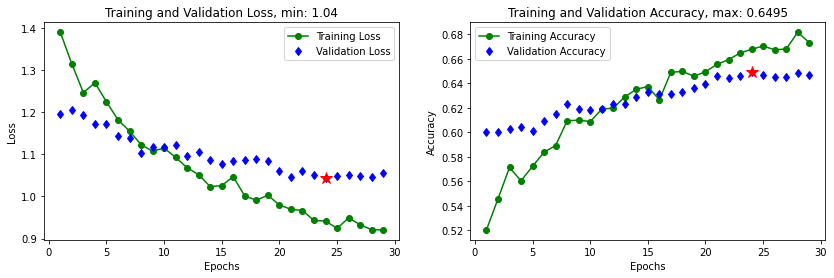

In [ ]:
# More graphs of loss and accuracy
history_dict = hist.history
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure(figsize=(14, 4))

plt.subplot(1,2,1)
plt.plot(epochs, loss, 'go-', label='Training Loss')
plt.plot(epochs, val_loss, 'bd', label='Validation Loss')
plt.plot(np.argmin(np.array(val_loss))+1,val_loss[np.argmin(np.array(val_loss))], 'r*', ms=12)
plt.title('Training and Validation Loss, min: ' + str(np.round(val_loss[np.argmin(np.array(val_loss))],2)))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

epochs = range(1, len(loss) + 1)

plt.subplot(1,2,2)
plt.plot(epochs, acc, 'go-', label='Training Accuracy') #, c='blue')
plt.plot(epochs, val_acc, 'bd', label='Validation Accuracy') #, c='red')
plt.plot(np.argmax(np.array(val_acc))+1,val_acc[np.argmax(np.array(val_acc))], 'r*', ms=12)
plt.title('Training and Validation Accuracy, max: ' + str(np.round(val_acc[np.argmax(np.array(val_acc))],4)))
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# Unfreeze all layers in base model
tf.keras.backend.clear_session()  # For memory
TL_base.trainable = True

In [ ]:
# Fine-tune from this layer onwards
fine_tune_at = 107  # 81, 107 for mobilenetV2

# Freeze all the layers before the `fine_tune_at` layer
for layer in TL_base.layers[:fine_tune_at]:
  layer.trainable =  False

In [ ]:
# Compile model
model.compile(optimizer='SGD', 
                loss='sparse_categorical_crossentropy',  # sparse_categorical_crossentropy
                metrics = ['accuracy'])

In [ ]:
mc_callback = callbacks.ModelCheckpoint(filepath="./model/cifar10_pct100_mobileNetV2S_FT_SGD_best_weights.{epoch:03d}-{val_accuracy:.4f}.hdf5", 
                              monitor='val_accuracy', verbose=0, save_best_only=True)
es_callback = callbacks.EarlyStopping(monitor='val_accuracy', 
                            mode='max', verbose=1, patience=5)

In [ ]:
history_dict = history.history
loss = history_dict['loss']

In [ ]:
INITIAL_EPOCHS = len(loss)
FINE_TUNE_EPOCHS = 100
TOTAL_EPOCHS = INITIAL_EPOCHS + FINE_TUNE_EPOCHS #

In [ ]:
%%time
history_fine = model.fit(x_train, y_train, 
                    epochs=TOTAL_EPOCHS, 
                    initial_epoch=INITIAL_EPOCHS,
                    batch_size=32, 
                    validation_data=(x_test, y_test),
                    callbacks=[mc_callback,es_callback])

Epoch 27/126
157/157 [==============================] - ETA: 0s - loss: 0.9846 - accuracy: 0.6586

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


157/157 [==============================] - 97s 266ms/step - loss: 0.9846 - accuracy: 0.6586 - val_loss: 1.6739 - val_accuracy: 0.4824
Epoch 28/126
157/157 [==============================] - 40s 258ms/step - loss: 0.5199 - accuracy: 0.8214 - val_loss: 1.5246 - val_accuracy: 0.5389
Epoch 29/126
157/157 [==============================] - 40s 258ms/step - loss: 0.3442 - accuracy: 0.8896 - val_loss: 1.3039 - val_accuracy: 0.5718
Epoch 30/126
157/157 [==============================] - 40s 258ms/step - loss: 0.2367 - accuracy: 0.9284 - val_loss: 1.1034 - val_accuracy: 0.6215
Epoch 31/126
157/157 [==============================] - 40s 257ms/step - loss: 0.1672 - accuracy: 0.9536 - val_loss: 1.1139 - val_accuracy: 0.6284
Epoch 32/126
157/157 [==============================] - 40s 258ms/step - loss: 0.1332 - accuracy: 0.9620 - val_loss: 1.0809 - val_accuracy: 0.6550
Epoch 33/126
157/157 [==============================] - 40s 258ms/step - loss: 0.1036 - accuracy: 0.9722 - val_loss: 1.0052 - val_a

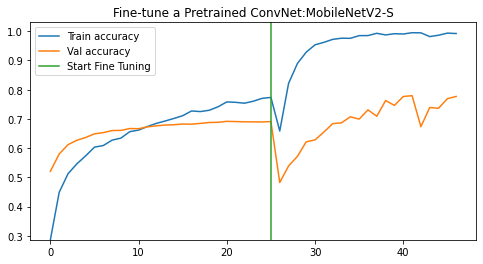

In [ ]:
# Display training curve

acc = history.history['accuracy'] + history_fine.history['accuracy']
val_acc = history.history['val_accuracy'] + history_fine.history['val_accuracy']

plt.figure(figsize=(8, 4))

plt.plot(acc, label='Train accuracy')
plt.plot(val_acc, label='Val accuracy')
# plt.ylim([0.8, 1])
plt.plot([INITIAL_EPOCHS-1, INITIAL_EPOCHS-1], plt.ylim(ymin=acc[0]), label='Start Fine Tuning')
plt.title("Fine-tune a Pretrained ConvNet:MobileNetV2-S")
plt.legend(loc='upper left')

plt.show()

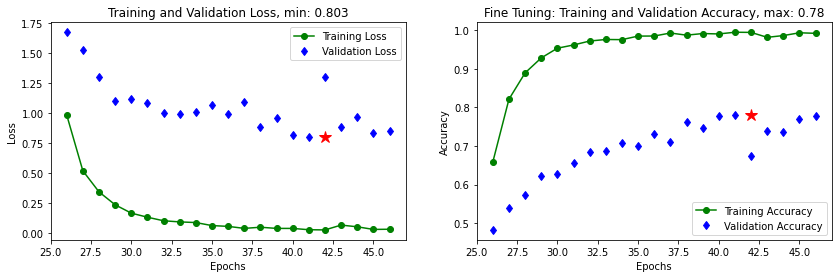

In [ ]:
# More graphs of loss and accuracy in Fine Tuning
history_dict = history_fine.history
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(INITIAL_EPOCHS, INITIAL_EPOCHS+len(loss))

plt.figure(figsize=(14, 4))

plt.subplot(1,2,1)
plt.plot(epochs, loss, 'go-', label='Training Loss')
plt.plot(epochs, val_loss, 'bd', label='Validation Loss')
plt.plot(INITIAL_EPOCHS + np.argmin(np.array(val_loss))+1,val_loss[np.argmin(np.array(val_loss))], 'r*', ms=12)
plt.title('Training and Validation Loss, min: ' + str(np.round(val_loss[np.argmin(np.array(val_loss))],3)))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

# epochs = range(1, len(loss_values) + 1)

plt.subplot(1,2,2)
plt.plot(epochs, acc, 'go-', label='Training Accuracy')#, c='blue')
plt.plot(epochs, val_acc, 'bd', label='Validation Accuracy') #, c='red')
plt.plot(INITIAL_EPOCHS + np.argmax(np.array(val_acc))+1,val_acc[np.argmax(np.array(val_acc))], 'r*', ms=12)
plt.title('Fine Tuning: Training and Validation Accuracy, max: ' + str(np.round(val_acc[np.argmax(np.array(val_acc))],3)))
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

In [ ]:
from keras.models import load_model

model_best = load_model('./model/cifar10_pct100_mobileNetV2S_FT_SGD_best_weights.042-0.7796.hdf5')
model_best.evaluate(x_test, y_test, batch_size=32)

313/313 [==============================] - 26s 80ms/step - loss: 0.8028 - accuracy: 0.7796


[0.8028047680854797, 0.7796000242233276]

In [ ]:
from sklearn.metrics import confusion_matrix

predictions = model_best.predict(x_test)
predictions0 = np.argmax(predictions, axis=1)
cm = confusion_matrix(y_test, predictions0)

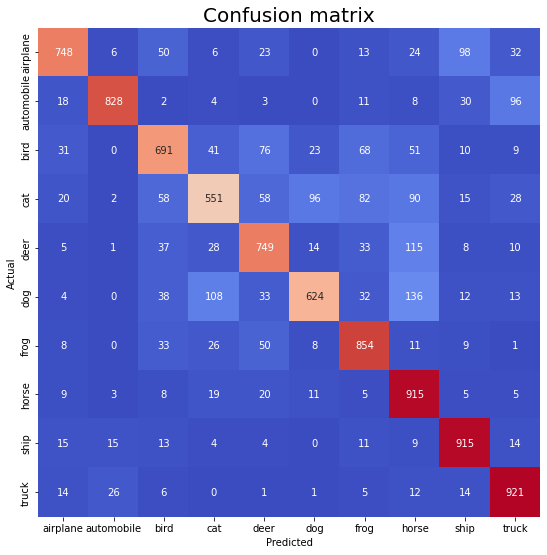

In [ ]:
import seaborn as sns
plt.figure(figsize=(9,9))
sns.heatmap(cm, cbar=False, xticklabels=class_names, yticklabels=class_names, fmt='d', annot=True, cmap=plt.cm.coolwarm)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion matrix', fontsize=20)
plt.show()